In [ ]:
! pip install -q --upgrade transformers diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 116.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.9 MB/s eta 0:00:00


In [ ]:
import os
import torch
import PIL
from PIL import Image
from diffusers import StableDiffusionPipeline, DiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
import numpy as np
import cv2
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T
#import albumentations as A
#elastic_transformer = T.ElasticTransform(alpha=550.0,sigma=5.0)
#isonoise_transformer = A.augmentations.transforms.ISONoise(always_apply=True, p=1)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# large or small model

# pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"
# pipe = DiffusionPipeline.from_pretrained(
#     pretrained_model_name_or_path,
#     torch_dtype=torch.float16
# ).to("cuda")

pretrained_model_name_or_path = "segmind/tiny-sd"
pipe = DiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    torch_dtype=torch.float16
)

unet/diffusion_pytorch_model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
pipe = pipe.to("cuda")

In [ ]:
# functions

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def blue_loss(images):
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel

    #transformed_imgs = elastic_transformer(images) # 2,3,512,512
    #error = torch.abs(transformed_imgs - images).mean()

    #transformed_imgs = isonoise_transformer(image = images) # 2,3,512,512
    #error = torch.abs(transformed_imgs - images).mean()

    #transformed_imgs = T.Grayscale()(images)
    #error = torch.abs(transformed_imgs - images).mean()

    return error

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = pipe.vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1) # 0 to 1
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def get_focal_point(images):
    """
    Compute the differentiable 'focal point' of a batch of images based on brightness.

    Args:
    - images (torch.Tensor): A tensor representation of the batch of images in BxCxHxW format.

    Returns:
    - tuple: The (x, y) coordinates of the focal points for each image in the batch.
    """
    # Convert images to grayscale if they're not
    if images.shape[1] == 3:  # Assuming images are in BxCxHxW format
        images = (0.299 * images[:, 0] + 0.587 * images[:, 1] + 0.114 * images[:, 2]).unsqueeze(1)

    # Create meshgrid of image coordinates
    x_coords = torch.linspace(0, 1, images.shape[3]).to(images.device)
    y_coords = torch.linspace(0, 1, images.shape[2]).to(images.device)
    xx, yy = torch.meshgrid(x_coords, y_coords)
    xx, yy = xx.unsqueeze(0), yy.unsqueeze(0)  # Add batch dimension

    # Compute weighted average of coordinates
    focal_x = torch.sum(images * xx, dim=(2, 3)) / torch.sum(images, dim=(2, 3))
    focal_y = torch.sum(images * yy, dim=(2, 3)) / torch.sum(images, dim=(2, 3))

    return focal_x, focal_y




def golden_ratio_loss(images):
    golden_ratio = 1.618
    focal_x, focal_y = get_focal_point(images)

    # Calculate distances from the focal point to the corners
    top_left = torch.sqrt(focal_x**2 + focal_y**2)
    top_right = torch.sqrt((1 - focal_x)**2 + focal_y**2)
    bottom_left = torch.sqrt(focal_x**2 + (1 - focal_y)**2)
    bottom_right = torch.sqrt((1 - focal_x)**2 + (1 - focal_y)**2)

    # Compute the deviation of these distances from the golden ratio
    deviations = torch.stack([
        torch.abs(top_left - golden_ratio) / golden_ratio,
        torch.abs(top_right - golden_ratio) / golden_ratio,
        torch.abs(bottom_left - golden_ratio) / golden_ratio,
        torch.abs(bottom_right - golden_ratio) / golden_ratio
    ], dim=1)

    return deviations.mean(dim=1).mean()


import torch.nn.functional as F

def symmetry_loss(image):
    """
    Calculate the symmetry loss for an image.

    Args:
    - image (torch.Tensor): The input image tensor of shape (batch_size, channels, height, width).

    Returns:
    - torch.Tensor: The symmetry loss for the image.
    """
    # Flip the image along the width
    flipped_image = torch.flip(image, [3])

    # Compute the mean squared error between the original and flipped image
    loss = F.mse_loss(image, flipped_image)

    return loss


In [ ]:
# Load SD concepts
sdconcepts = ['<meeg>', '<ouroboros>', '<birb-style>', '<babs_bunny>', '<beetlejuice-cartoon>']
sdconcepts = sdconcepts[:4]

In [ ]:
# Load SD concepts
sdconcepts = ['<meeg>', '<ouroboros>', '<birb-style>', '<babs_bunny>', '<beetlejuice-cartoon>']
pipe.load_textual_inversion("sd-concepts-library/dreams") #  <meeg>
pipe.load_textual_inversion("sd-concepts-library/birb-style") # <birb-style>
pipe.load_textual_inversion("sd-concepts-library/babs-bunny") # <babs_bunny>
pipe.load_textual_inversion("sd-concepts-library/beetlejuice-cartoon-style") # <beetlejuice-cartoon>
pipe.load_textual_inversion("sd-concepts-library/ouroboros") # <ouroboros>

In [ ]:
# configurations

torch_device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size          = len(sdconcepts)
height, width       = 320, 320 #512, 512
guidance_scale      = 7
blue_loss_scale     = 200
num_inference_steps = 50
generator           = torch.manual_seed(2000)
use_all_sd   = True
custom_loss  = True

In [ ]:
if use_all_sd:
    prompt = """A beautiful sorceress in the style of"""
    prompts = [f'{prompt} {sd}' for sd in sdconcepts]
else:
    sdconcepts =  ['<meeg>']
    prompt  = """A campfire in the style of"""
    prompts = [f'{prompt} {sd}' for sd in sdconcepts]

# scheduler
scheduler    = LMSDiscreteScheduler(beta_start = 0.00085, beta_end = 0.012, beta_schedule = "scaled_linear", num_train_timesteps = 1000)
scheduler.set_timesteps(num_inference_steps)
scheduler.timesteps = scheduler.timesteps.to(torch.float32)

# text embeddings of the prompt
text_input = pipe.tokenizer(prompts, padding='max_length', max_length = pipe.tokenizer.model_max_length, truncation= True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

with torch.no_grad():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = pipe.tokenizer(
      [""] * batch_size, padding="max_length", max_length= max_length, return_tensors="pt"
)

with torch.no_grad():
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings,text_embeddings]) # 2,77,768

# random latent
latents = torch.randn(
    (batch_size, pipe.unet.config.in_channels, height// 8, width //8),
    generator = generator,
).to(torch.float16)

latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

for i, t in tqdm(enumerate(scheduler.timesteps), total = len(scheduler.timesteps)):

    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input.to(torch.float16), t, encoder_hidden_states=text_embeddings)["sample"]

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    if i%5 == 0 and custom_loss:
        latents = latents.detach().requires_grad_()
        latents_x0 = latents - sigma * noise_pred

        # use vae to decode the image
        denoised_images = pipe.vae.decode((1/ 0.18215) * latents_x0).sample / 2 + 0.5
        loss = symmetry_loss(denoised_images) * blue_loss_scale

        print(f"loss {loss}")

        cond_grad = torch.autograd.grad(loss, latents)[0]

        latents = latents.detach() - cond_grad * sigma**2

    latents = scheduler.step(noise_pred,t, latents).prev_sample

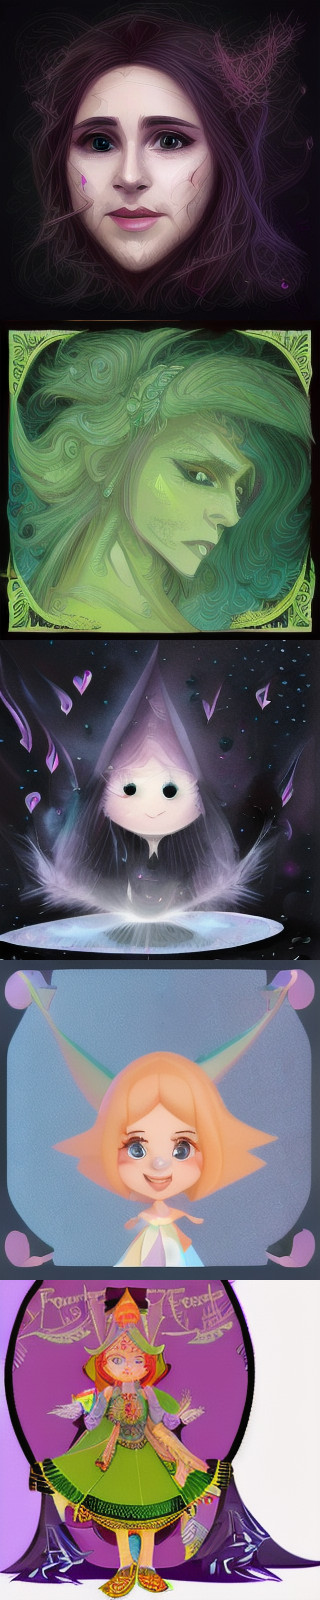

In [ ]:
# original image
images = latents_to_pil(latents)
image_grid(images, len(images), 1)

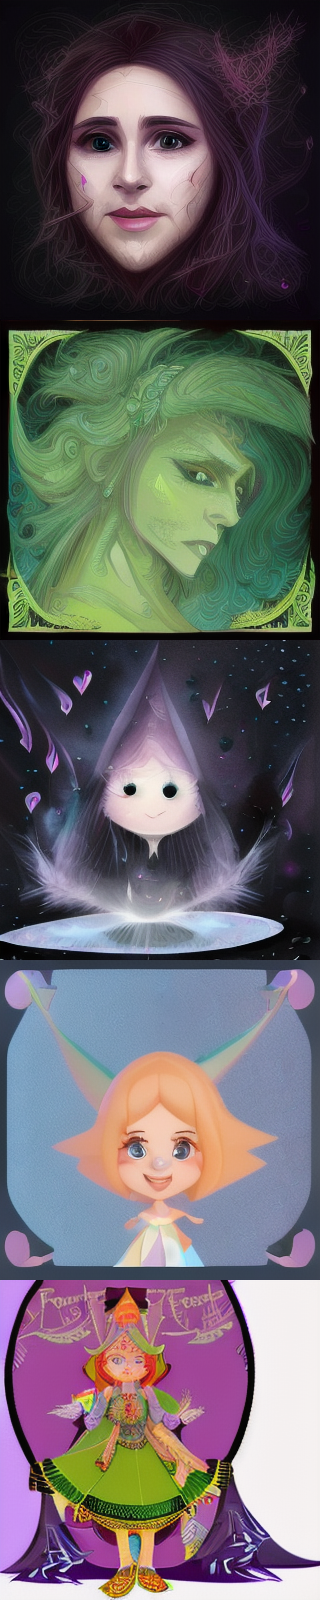

In [ ]:
# after loss is applied
images = latents_to_pil(latents)
image_grid(images, len(images), 1)